In [1]:
from load_dataset.artgraph import ArtGraph
from utils.MultiTaskLinkSplitter import MultiTaskLinkSplitter
from utils.dataset import TrainingDataSet, TestDataSet
from utils.EarlyStopping import EarlyStopping
from multi_task_model import MultiTaskClassificationModel, NewMultiTaskClassificationModel
from torch import nn
from utils.training_utils import fine_tune, test as test_func, compute_topk, plot_confusion_matrix
from torch.utils.data import DataLoader
from torch import optim
import torch
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
root = 'artgraph2bestemotions'
data_path = 'data_full_labels.csv'
root_dataset = 'common_dataset'

In [4]:
data = ArtGraph(root = root, preprocess='constant', features = 'vit', fine_tuning = True)[0]
data

Processing...
Done!


HeteroData(
  artwork={ x=[116475, 128] },
  artist={ x=[2501, 1] },
  gallery={ x=[1099, 1] },
  city={ x=[596, 1] },
  country={ x=[58, 1] },
  style={ x=[32, 1] },
  period={ x=[186, 1] },
  genre={ x=[18, 1] },
  serie={ x=[823, 1] },
  tag={ x=[5424, 1] },
  media={ x=[167, 1] },
  subject={ x=[6985, 1] },
  training_node={ x=[268, 1] },
  field={ x=[54, 1] },
  movement={ x=[243, 1] },
  people={ x=[109, 1] },
  emotion={ x=[9, 1] },
  (artist, belongstofield, field)={ edge_index=[2, 987] },
  (artist, belongstomovement, movement)={ edge_index=[2, 1056] },
  (artist, haspatron, people)={ edge_index=[2, 124] },
  (artist, hassubject, subject)={ edge_index=[2, 21054] },
  (artist, relatedtoschool, training_node)={ edge_index=[2, 498] },
  (artist, trainedby, artist)={ edge_index=[2, 47] },
  (artwork, about, tag)={ edge_index=[2, 342982] },
  (artwork, createdby, artist)={ edge_index=[2, 116475] },
  (artwork, elicit, emotion)={ edge_index=[2, 65236] },
  (artwork, hasgenre, genre)

In [5]:
train = torch.load(f'{root_dataset}/train_data.pt')
val = torch.load(f'{root_dataset}/val_set.pt')
test = torch.load(f'{root_dataset}/test_set.pt')

In [6]:
#loading data with labels
data_labels = pd.read_csv(data_path)
data_labels.index = data_labels.artwork
data_labels['style'] -= 1
data_labels

,artwork,style,genre,emotion
artwork,,,,
81418,81418,0,4,4
28493,28493,2,9,5
28421,28421,2,3,8
28393,28393,2,9,8
28380,28380,2,9,7
...,...,...,...,...
71300,71300,9,6,8
68290,68290,22,6,8
68567,68567,22,6,8


In [7]:
train_dataset = TrainingDataSet(graph = train, data_labels = data_labels)

In [8]:
val_dataset = TestDataSet(graph = train, x_test = val, data_labels = data_labels)

In [9]:
test_dataset = TestDataSet(graph = train, x_test = test, data_labels = data_labels)

Test per vedere se va bene il modello pre-trained

In [10]:
device = torch.device('cuda:0')
genre_model = torch.load('genre.pt').to(device)
genre_model

ModelClassification(
  (encoder): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (decoder): Head(
    (head): Sequential(
      (0): Linear(in_features=2432, out_features=1216, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=1216, out_features=608, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=608, out_features=304, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): Linear(in_features=304, out_features=152, bias=True)
      (10): LeakyReLU(negative_slope=0.1, inplace=True)
      (11): Dropout(p=0.25, inplace=False)
      (12): Linear(in_features=152, out_features=18, bias=True)
    )
  )
)

In [11]:
from tqdm import tqdm
device = torch.device('cuda:0')
train = train.to(device)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False, drop_last = False)
with torch.no_grad():
    running_corrects = 0 
    for _, images, (style_labels, genre_labels, emotion_labels) in tqdm(test_loader):
        images = images.to(device, non_blocking = True)
        genre_labels = genre_labels.to(device, non_blocking = True)
        genre_pred = genre_model(train.x_dict, train.edge_index_dict, images)
        running_corrects += torch.sum(torch.max(genre_pred, 1)[1] == genre_labels)
    print(f'Acc: {running_corrects/len(test_loader.dataset)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.63it/s]

Acc: 0.8140996694564819


## INSTANTIATING MODEL

In [12]:
device = torch.device('cuda:0')
style_encoder = torch.load('best_model_style_single_task.pt').encoder
genre_encoder = torch.load('best_model_genre_single_task.pt').encoder
emotion_encoder = torch.load('best_model_emotion_single_task.pt').encoder
model = NewMultiTaskClassificationModel(data = data, hidden_channels=None, head_num_layers=5,
                                        encoders = (style_encoder, genre_encoder, emotion_encoder)).to(device)

In [13]:
model

NewMultiTaskClassificationModel(
  (encoder_style): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_genre): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (encoder_emotion): MultiGNNEncoder(
    (activation): Tanh()
    (encoders): ModuleDict(
      (0): HeteroConv(num_relations=1)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=7680, out_features=3840, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=3840, out_features=1920, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1920, out_features=960, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=960, out_features=480, bias=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
  )
  (

In [14]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder_style(train.x_dict, train.edge_index_dict)
    model.encoder_genre(train.x_dict, train.edge_index_dict)
    model.encoder_emotion(train.x_dict, train.edge_index_dict)

In [15]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_new_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:21<00:00, 18.55it/s]


train Loss: 1.7736 Style Acc: 0.3227
            Genre Acc: 0.5484
            Emotion Acc: 0.3835


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.99it/s]


val Loss: 1.4812 Style Acc: 0.4369
            Genre Acc: 0.6445
            Emotion Acc: 0.4219
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.86it/s]


train Loss: 1.4421 Style Acc: 0.4480
            Genre Acc: 0.6692
            Emotion Acc: 0.4124


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.75it/s]


val Loss: 1.3705 Style Acc: 0.4822
            Genre Acc: 0.6869
            Emotion Acc: 0.4283
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.35it/s]


train Loss: 1.3717 Style Acc: 0.4863
            Genre Acc: 0.6845
            Emotion Acc: 0.4199


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 59.18it/s]


val Loss: 1.3453 Style Acc: 0.4988
            Genre Acc: 0.6903
            Emotion Acc: 0.4409
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.29it/s]


train Loss: 1.3309 Style Acc: 0.5071
            Genre Acc: 0.6947
            Emotion Acc: 0.4264


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.03it/s]


val Loss: 1.3159 Style Acc: 0.5216
            Genre Acc: 0.6904
            Emotion Acc: 0.4352
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.03it/s]


train Loss: 1.3055 Style Acc: 0.5215
            Genre Acc: 0.6995
            Emotion Acc: 0.4283


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.57it/s]


val Loss: 1.2862 Style Acc: 0.5351
            Genre Acc: 0.7060
            Emotion Acc: 0.4297
Validation loss decreased. Saving model...
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.04it/s]


train Loss: 1.2825 Style Acc: 0.5338
            Genre Acc: 0.7043
            Emotion Acc: 0.4323


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 53.98it/s]


val Loss: 1.2757 Style Acc: 0.5415
            Genre Acc: 0.7053
            Emotion Acc: 0.4344
Validation loss decreased. Saving model...
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.79it/s]


train Loss: 1.2585 Style Acc: 0.5504
            Genre Acc: 0.7106
            Emotion Acc: 0.4353


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.44it/s]


val Loss: 1.2806 Style Acc: 0.5463
            Genre Acc: 0.7096
            Emotion Acc: 0.4361
EarlyStopping counter: 1 out of 5
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.69it/s]


train Loss: 1.2405 Style Acc: 0.5572
            Genre Acc: 0.7151
            Emotion Acc: 0.4383


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.38it/s]


val Loss: 1.2616 Style Acc: 0.5378
            Genre Acc: 0.7143
            Emotion Acc: 0.4383
Validation loss decreased. Saving model...
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.53it/s]


train Loss: 1.2272 Style Acc: 0.5639
            Genre Acc: 0.7201
            Emotion Acc: 0.4413


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 55.09it/s]


val Loss: 1.2353 Style Acc: 0.5588
            Genre Acc: 0.7197
            Emotion Acc: 0.4470
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.06it/s]


train Loss: 1.2095 Style Acc: 0.5729
            Genre Acc: 0.7249
            Emotion Acc: 0.4425


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.36it/s]


val Loss: 1.2299 Style Acc: 0.5702
            Genre Acc: 0.7223
            Emotion Acc: 0.4415
Validation loss decreased. Saving model...
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.20it/s]


train Loss: 1.1990 Style Acc: 0.5786
            Genre Acc: 0.7259
            Emotion Acc: 0.4438


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.30it/s]


val Loss: 1.2336 Style Acc: 0.5643
            Genre Acc: 0.7163
            Emotion Acc: 0.4381
EarlyStopping counter: 1 out of 5
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.11it/s]


train Loss: 1.1828 Style Acc: 0.5855
            Genre Acc: 0.7311
            Emotion Acc: 0.4472


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.84it/s]


val Loss: 1.2180 Style Acc: 0.5712
            Genre Acc: 0.7253
            Emotion Acc: 0.4406
Validation loss decreased. Saving model...
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.21it/s]


train Loss: 1.1708 Style Acc: 0.5941
            Genre Acc: 0.7360
            Emotion Acc: 0.4490


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.17it/s]


val Loss: 1.2171 Style Acc: 0.5752
            Genre Acc: 0.7287
            Emotion Acc: 0.4430
EarlyStopping counter: 1 out of 5
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.81it/s]


train Loss: 1.1560 Style Acc: 0.6015
            Genre Acc: 0.7405
            Emotion Acc: 0.4491


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 52.48it/s]


val Loss: 1.2106 Style Acc: 0.5744
            Genre Acc: 0.7289
            Emotion Acc: 0.4433
Validation loss decreased. Saving model...
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.75it/s]


train Loss: 1.1437 Style Acc: 0.6078
            Genre Acc: 0.7403
            Emotion Acc: 0.4496


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.30it/s]


val Loss: 1.1987 Style Acc: 0.5895
            Genre Acc: 0.7259
            Emotion Acc: 0.4416
Validation loss decreased. Saving model...
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.45it/s]


train Loss: 1.1339 Style Acc: 0.6129
            Genre Acc: 0.7462
            Emotion Acc: 0.4529


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.12it/s]


val Loss: 1.1934 Style Acc: 0.5878
            Genre Acc: 0.7267
            Emotion Acc: 0.4435
Validation loss decreased. Saving model...
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.75it/s]


train Loss: 1.1213 Style Acc: 0.6199
            Genre Acc: 0.7492
            Emotion Acc: 0.4533


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.57it/s]


val Loss: 1.2034 Style Acc: 0.5916
            Genre Acc: 0.7191
            Emotion Acc: 0.4433
EarlyStopping counter: 1 out of 5
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.28it/s]


train Loss: 1.1094 Style Acc: 0.6268
            Genre Acc: 0.7533
            Emotion Acc: 0.4549


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.38it/s]


val Loss: 1.2000 Style Acc: 0.5945
            Genre Acc: 0.7253
            Emotion Acc: 0.4375
Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.20it/s]


train Loss: 1.0700 Style Acc: 0.6456
            Genre Acc: 0.7654
            Emotion Acc: 0.4602


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.10it/s]


val Loss: 1.1619 Style Acc: 0.6063
            Genre Acc: 0.7367
            Emotion Acc: 0.4456
Validation loss decreased. Saving model...
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.20it/s]


train Loss: 1.0555 Style Acc: 0.6549
            Genre Acc: 0.7716
            Emotion Acc: 0.4640


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.71it/s]


val Loss: 1.1681 Style Acc: 0.6088
            Genre Acc: 0.7342
            Emotion Acc: 0.4447
EarlyStopping counter: 1 out of 5
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.96it/s]


train Loss: 1.0469 Style Acc: 0.6589
            Genre Acc: 0.7717
            Emotion Acc: 0.4644


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.85it/s]


val Loss: 1.1652 Style Acc: 0.6055
            Genre Acc: 0.7351
            Emotion Acc: 0.4475
Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.57it/s]


train Loss: 1.0245 Style Acc: 0.6705
            Genre Acc: 0.7790
            Emotion Acc: 0.4687


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 54.55it/s]


val Loss: 1.1477 Style Acc: 0.6149
            Genre Acc: 0.7448
            Emotion Acc: 0.4459
Validation loss decreased. Saving model...
Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.67it/s]


train Loss: 1.0172 Style Acc: 0.6730
            Genre Acc: 0.7791
            Emotion Acc: 0.4699


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.68it/s]


val Loss: 1.1479 Style Acc: 0.6132
            Genre Acc: 0.7405
            Emotion Acc: 0.4419
EarlyStopping counter: 1 out of 5
Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.49it/s]


train Loss: 1.0109 Style Acc: 0.6770
            Genre Acc: 0.7829
            Emotion Acc: 0.4687


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.32it/s]


val Loss: 1.1454 Style Acc: 0.6155
            Genre Acc: 0.7420
            Emotion Acc: 0.4409
Validation loss decreased. Saving model...
Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:14<00:00, 27.26it/s]


train Loss: 1.0041 Style Acc: 0.6763
            Genre Acc: 0.7856
            Emotion Acc: 0.4705


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.64it/s]


val Loss: 1.1460 Style Acc: 0.6166
            Genre Acc: 0.7434
            Emotion Acc: 0.4450
EarlyStopping counter: 1 out of 5
Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.16it/s]


train Loss: 0.9999 Style Acc: 0.6833
            Genre Acc: 0.7858
            Emotion Acc: 0.4705


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.93it/s]


val Loss: 1.1438 Style Acc: 0.6170
            Genre Acc: 0.7423
            Emotion Acc: 0.4459
Validation loss decreased. Saving model...
Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.10it/s]


train Loss: 0.9947 Style Acc: 0.6832
            Genre Acc: 0.7875
            Emotion Acc: 0.4734


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 59.39it/s]


val Loss: 1.1450 Style Acc: 0.6141
            Genre Acc: 0.7399
            Emotion Acc: 0.4404
EarlyStopping counter: 1 out of 5
Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.14it/s]


train Loss: 0.9890 Style Acc: 0.6875
            Genre Acc: 0.7893
            Emotion Acc: 0.4737


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 52.05it/s]


val Loss: 1.1450 Style Acc: 0.6160
            Genre Acc: 0.7434
            Emotion Acc: 0.4436
Epoch 00028: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 2 out of 5
Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.68it/s]


train Loss: 0.9771 Style Acc: 0.6936
            Genre Acc: 0.7938
            Emotion Acc: 0.4745


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 53.86it/s]


val Loss: 1.1430 Style Acc: 0.6195
            Genre Acc: 0.7445
            Emotion Acc: 0.4433
EarlyStopping counter: 3 out of 5
Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.72it/s]


train Loss: 0.9726 Style Acc: 0.6969
            Genre Acc: 0.7955
            Emotion Acc: 0.4745


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.49it/s]


val Loss: 1.1394 Style Acc: 0.6186
            Genre Acc: 0.7460
            Emotion Acc: 0.4436
Validation loss decreased. Saving model...
Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.61it/s]


train Loss: 0.9694 Style Acc: 0.6969
            Genre Acc: 0.7958
            Emotion Acc: 0.4746


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 53.86it/s]


val Loss: 1.1392 Style Acc: 0.6199
            Genre Acc: 0.7446
            Emotion Acc: 0.4444
EarlyStopping counter: 1 out of 5
Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.89it/s]


train Loss: 0.9666 Style Acc: 0.6983
            Genre Acc: 0.7972
            Emotion Acc: 0.4763


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.49it/s]


val Loss: 1.1396 Style Acc: 0.6229
            Genre Acc: 0.7431
            Emotion Acc: 0.4436
EarlyStopping counter: 2 out of 5
Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.17it/s]


train Loss: 0.9634 Style Acc: 0.7029
            Genre Acc: 0.7974
            Emotion Acc: 0.4758


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.03it/s]


val Loss: 1.1409 Style Acc: 0.6186
            Genre Acc: 0.7445
            Emotion Acc: 0.4447
Epoch 00033: reducing learning rate of group 0 to 6.2500e-06.
EarlyStopping counter: 3 out of 5
Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.16it/s]


train Loss: 0.9556 Style Acc: 0.7047
            Genre Acc: 0.8004
            Emotion Acc: 0.4769


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.03it/s]


val Loss: 1.1375 Style Acc: 0.6216
            Genre Acc: 0.7460
            Emotion Acc: 0.4435
Validation loss decreased. Saving model...
Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.09it/s]


train Loss: 0.9554 Style Acc: 0.7038
            Genre Acc: 0.8012
            Emotion Acc: 0.4784


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 59.04it/s]


val Loss: 1.1390 Style Acc: 0.6236
            Genre Acc: 0.7463
            Emotion Acc: 0.4419
EarlyStopping counter: 1 out of 5
Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 26.99it/s]


train Loss: 0.9521 Style Acc: 0.7062
            Genre Acc: 0.8012
            Emotion Acc: 0.4774


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.37it/s]


val Loss: 1.1399 Style Acc: 0.6212
            Genre Acc: 0.7456
            Emotion Acc: 0.4424
Epoch 00036: reducing learning rate of group 0 to 3.1250e-06.
EarlyStopping counter: 2 out of 5
Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.14it/s]


train Loss: 0.9496 Style Acc: 0.7051
            Genre Acc: 0.8038
            Emotion Acc: 0.4794


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 57.06it/s]


val Loss: 1.1388 Style Acc: 0.6216
            Genre Acc: 0.7454
            Emotion Acc: 0.4416
EarlyStopping counter: 3 out of 5
Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.05it/s]


train Loss: 0.9476 Style Acc: 0.7110
            Genre Acc: 0.8035
            Emotion Acc: 0.4796


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 56.80it/s]


val Loss: 1.1371 Style Acc: 0.6242
            Genre Acc: 0.7465
            Emotion Acc: 0.4409
EarlyStopping counter: 4 out of 5
Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:15<00:00, 27.17it/s]


train Loss: 0.9468 Style Acc: 0.7072
            Genre Acc: 0.8037
            Emotion Acc: 0.4788


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.03it/s]

val Loss: 1.1373 Style Acc: 0.6232
            Genre Acc: 0.7448
            Emotion Acc: 0.4426
EarlyStopping counter: 5 out of 5
Best epoch: 0038
Best loss: 1.1371


In [15]:
model = torch.load('best_new_multitask_model.pt').to('cuda:0')
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train, update_graph=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 20.19it/s]


In [16]:
pred = {k: v.argmax(dim = 1).tolist() for k, v in pred.items()}

In [17]:
import json
with open('preds.json', 'w+') as f:
    json.dump(pred, f)
with open('labs.json', 'w+') as f:
    json.dump(lab, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 59.66it/s]


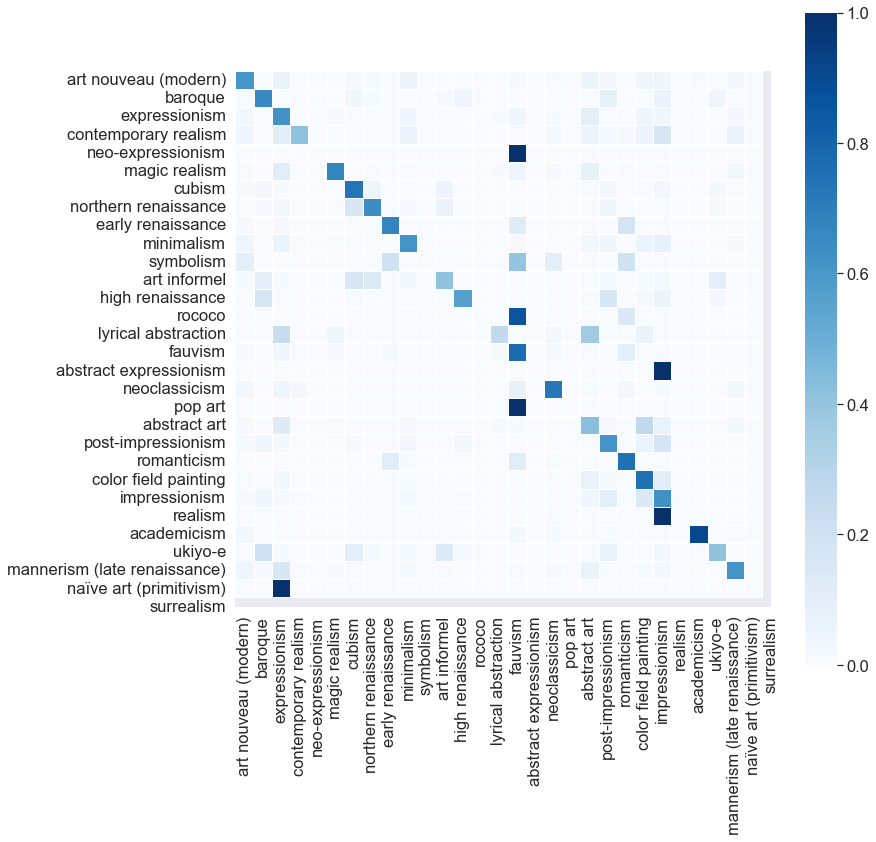

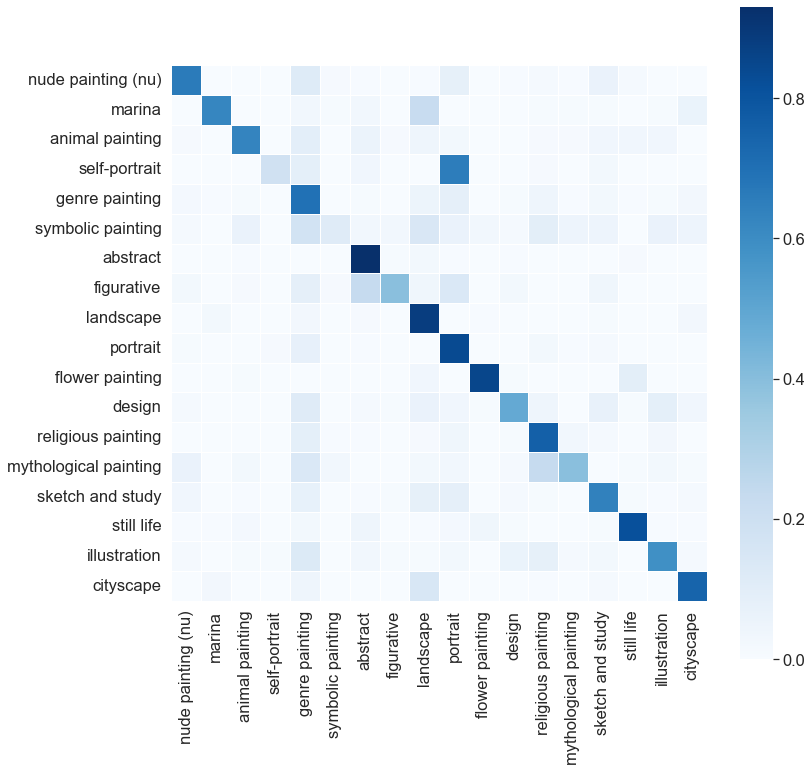

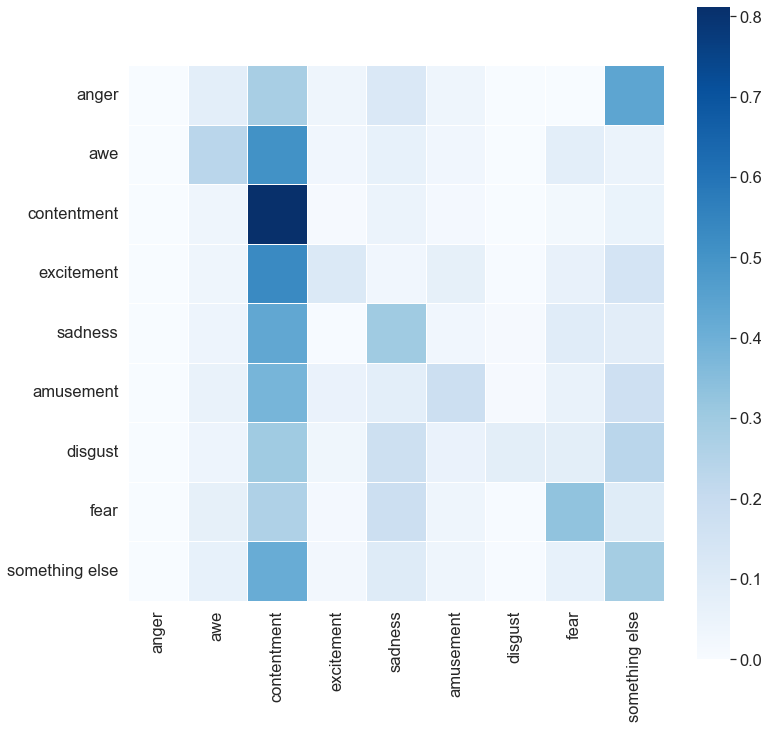

In [16]:
model = torch.load('best_new_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [17]:
results_df.to_csv('results_multi_task_fine_tuning.csv')

In [18]:
model = torch.load('best_new_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train, update_graph=True)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    #plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 30.10it/s]


In [19]:
results_df

,Top1,Top2,Macro-F1
style,0.63295,0.805211,0.47451
genre,0.753257,0.885057,0.636916
emotion,0.455172,0.638621,0.273231


In [20]:
results_df.to_csv('results_multi_task_fine_tuning_update.csv')

Nuovo test, senza encoder pre-trained

In [21]:
model = MultiTaskClassificationModel(data = train, hidden_channels = 128, head_num_layers = 5).to(device)
model

MultiTaskClassificationModel(
  (encoder): GraphModule(
    (convs): ModuleList(
      (0): ModuleDict(
        (artist__belongstofield__field): GATConv((-1, -1), 128, heads=1)
        (artist__belongstomovement__movement): GATConv((-1, -1), 128, heads=1)
        (artist__haspatron__people): GATConv((-1, -1), 128, heads=1)
        (artist__hassubject__subject): GATConv((-1, -1), 128, heads=1)
        (artist__relatedtoschool__training_node): GATConv((-1, -1), 128, heads=1)
        (artist__trainedby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__about__tag): GATConv((-1, -1), 128, heads=1)
        (artwork__createdby__artist): GATConv((-1, -1), 128, heads=1)
        (artwork__elicit__emotion): GATConv((-1, -1), 128, heads=1)
        (artwork__hasgenre__genre): GATConv((-1, -1), 128, heads=1)
        (artwork__hasperiod__period): GATConv((-1, -1), 128, heads=1)
        (artwork__hasstyle__style): GATConv((-1, -1), 128, heads=1)
        (artwork__locatedin__city): GATConv((-

In [22]:
from torch_geometric.transforms import ToUndirected
train = ToUndirected()(train).to(device)
with torch.no_grad():
    model.encoder(train.x_dict, train.edge_index_dict)

In [23]:
batch_size = 128
num_epochs = 50
criterions = list(nn.CrossEntropyLoss() for _ in range(3))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop= EarlyStopping(patience = 5, min_delta = 1e-3, checkpoint_path = 'best_multitask_model.pt')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, drop_last = False)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-7, verbose = True, factor = .5, patience = 1,
                                               threshold = 1e-4)
fine_tune(model, train, train_loader, val_loader, criterions, optimizer, early_stop, scheduler, num_epochs)

Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.22it/s]


train Loss: 1.8264 Style Acc: 0.3025
            Genre Acc: 0.5284
            Emotion Acc: 0.3808


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.31it/s]


val Loss: 1.4965 Style Acc: 0.4229
            Genre Acc: 0.6585
            Emotion Acc: 0.4177
Validation loss decreased. Saving model...
Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.33it/s]


train Loss: 1.4721 Style Acc: 0.4319
            Genre Acc: 0.6585
            Emotion Acc: 0.4105


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.27it/s]


val Loss: 1.3872 Style Acc: 0.4698
            Genre Acc: 0.6786
            Emotion Acc: 0.4344
Validation loss decreased. Saving model...
Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.3914 Style Acc: 0.4715
            Genre Acc: 0.6781
            Emotion Acc: 0.4182


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.29it/s]


val Loss: 1.3777 Style Acc: 0.4914
            Genre Acc: 0.6677
            Emotion Acc: 0.4314
Validation loss decreased. Saving model...
Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.32it/s]


train Loss: 1.3587 Style Acc: 0.4916
            Genre Acc: 0.6860
            Emotion Acc: 0.4236


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.29it/s]


val Loss: 1.3371 Style Acc: 0.5043
            Genre Acc: 0.7017
            Emotion Acc: 0.4243
Validation loss decreased. Saving model...
Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.32it/s]


train Loss: 1.3287 Style Acc: 0.5074
            Genre Acc: 0.6931
            Emotion Acc: 0.4265


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.29it/s]


val Loss: 1.3388 Style Acc: 0.5026
            Genre Acc: 0.6910
            Emotion Acc: 0.4334
EarlyStopping counter: 1 out of 5
Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.34it/s]


train Loss: 1.3037 Style Acc: 0.5210
            Genre Acc: 0.7015
            Emotion Acc: 0.4304


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.36it/s]


val Loss: 1.2952 Style Acc: 0.5254
            Genre Acc: 0.7024
            Emotion Acc: 0.4295
Validation loss decreased. Saving model...
Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.2837 Style Acc: 0.5317
            Genre Acc: 0.7050
            Emotion Acc: 0.4344


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.2748 Style Acc: 0.5369
            Genre Acc: 0.7054
            Emotion Acc: 0.4320
Validation loss decreased. Saving model...
Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.2706 Style Acc: 0.5390
            Genre Acc: 0.7077
            Emotion Acc: 0.4351


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.2821 Style Acc: 0.5411
            Genre Acc: 0.7120
            Emotion Acc: 0.4320
EarlyStopping counter: 1 out of 5
Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.33it/s]


train Loss: 1.2518 Style Acc: 0.5500
            Genre Acc: 0.7111
            Emotion Acc: 0.4368


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.2698 Style Acc: 0.5447
            Genre Acc: 0.7050
            Emotion Acc: 0.4387
Validation loss decreased. Saving model...
Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.33it/s]


train Loss: 1.2361 Style Acc: 0.5583
            Genre Acc: 0.7166
            Emotion Acc: 0.4391


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.39it/s]


val Loss: 1.2364 Style Acc: 0.5565
            Genre Acc: 0.7217
            Emotion Acc: 0.4410
Validation loss decreased. Saving model...
Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.2233 Style Acc: 0.5641
            Genre Acc: 0.7191
            Emotion Acc: 0.4419


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.32it/s]


val Loss: 1.2317 Style Acc: 0.5616
            Genre Acc: 0.7209
            Emotion Acc: 0.4430
Validation loss decreased. Saving model...
Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.33it/s]


train Loss: 1.2117 Style Acc: 0.5690
            Genre Acc: 0.7224
            Emotion Acc: 0.4408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.2328 Style Acc: 0.5656
            Genre Acc: 0.7223
            Emotion Acc: 0.4297
EarlyStopping counter: 1 out of 5
Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 1.1997 Style Acc: 0.5778
            Genre Acc: 0.7276
            Emotion Acc: 0.4456


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.04it/s]


val Loss: 1.2236 Style Acc: 0.5692
            Genre Acc: 0.7215
            Emotion Acc: 0.4413
Validation loss decreased. Saving model...
Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.22it/s]


train Loss: 1.1886 Style Acc: 0.5832
            Genre Acc: 0.7296
            Emotion Acc: 0.4479


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.30it/s]


val Loss: 1.2031 Style Acc: 0.5813
            Genre Acc: 0.7235
            Emotion Acc: 0.4447
Validation loss decreased. Saving model...
Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.1765 Style Acc: 0.5914
            Genre Acc: 0.7338
            Emotion Acc: 0.4459


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.07it/s]


val Loss: 1.2168 Style Acc: 0.5738
            Genre Acc: 0.7267
            Emotion Acc: 0.4406
EarlyStopping counter: 1 out of 5
Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.23it/s]


train Loss: 1.1649 Style Acc: 0.5967
            Genre Acc: 0.7373
            Emotion Acc: 0.4473


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.2048 Style Acc: 0.5823
            Genre Acc: 0.7212
            Emotion Acc: 0.4398
Epoch 00016: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 5
Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.1290 Style Acc: 0.6146
            Genre Acc: 0.7467
            Emotion Acc: 0.4523


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.1882 Style Acc: 0.5918
            Genre Acc: 0.7348
            Emotion Acc: 0.4441
Validation loss decreased. Saving model...
Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.26it/s]


train Loss: 1.1174 Style Acc: 0.6173
            Genre Acc: 0.7510
            Emotion Acc: 0.4556


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1781 Style Acc: 0.5973
            Genre Acc: 0.7312
            Emotion Acc: 0.4452
Validation loss decreased. Saving model...
Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.27it/s]


train Loss: 1.1095 Style Acc: 0.6243
            Genre Acc: 0.7543
            Emotion Acc: 0.4560


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.22it/s]


val Loss: 1.1812 Style Acc: 0.5965
            Genre Acc: 0.7331
            Emotion Acc: 0.4456
EarlyStopping counter: 1 out of 5
Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.24it/s]


train Loss: 1.1020 Style Acc: 0.6283
            Genre Acc: 0.7555
            Emotion Acc: 0.4571


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.33it/s]


val Loss: 1.1725 Style Acc: 0.5991
            Genre Acc: 0.7410
            Emotion Acc: 0.4424
Validation loss decreased. Saving model...
Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.22it/s]


train Loss: 1.0955 Style Acc: 0.6289
            Genre Acc: 0.7573
            Emotion Acc: 0.4590


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.13it/s]


val Loss: 1.1720 Style Acc: 0.5983
            Genre Acc: 0.7373
            Emotion Acc: 0.4400
EarlyStopping counter: 1 out of 5
Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.26it/s]


train Loss: 1.0890 Style Acc: 0.6353
            Genre Acc: 0.7590
            Emotion Acc: 0.4598


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.38it/s]


val Loss: 1.1682 Style Acc: 0.6014
            Genre Acc: 0.7396
            Emotion Acc: 0.4422
Validation loss decreased. Saving model...
Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.23it/s]


train Loss: 1.0829 Style Acc: 0.6370
            Genre Acc: 0.7616
            Emotion Acc: 0.4593


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.18it/s]


val Loss: 1.1702 Style Acc: 0.6025
            Genre Acc: 0.7330
            Emotion Acc: 0.4470
EarlyStopping counter: 1 out of 5
Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.0752 Style Acc: 0.6398
            Genre Acc: 0.7628
            Emotion Acc: 0.4601


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.35it/s]


val Loss: 1.1712 Style Acc: 0.6006
            Genre Acc: 0.7388
            Emotion Acc: 0.4462
Epoch 00024: reducing learning rate of group 0 to 2.5000e-05.
EarlyStopping counter: 2 out of 5
Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.20it/s]


train Loss: 1.0539 Style Acc: 0.6515
            Genre Acc: 0.7712
            Emotion Acc: 0.4629


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.08it/s]


val Loss: 1.1553 Style Acc: 0.6063
            Genre Acc: 0.7391
            Emotion Acc: 0.4467
Validation loss decreased. Saving model...
Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.27it/s]


train Loss: 1.0486 Style Acc: 0.6559
            Genre Acc: 0.7710
            Emotion Acc: 0.4643


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.27it/s]


val Loss: 1.1566 Style Acc: 0.6108
            Genre Acc: 0.7437
            Emotion Acc: 0.4430
EarlyStopping counter: 1 out of 5
Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.23it/s]


train Loss: 1.0423 Style Acc: 0.6566
            Genre Acc: 0.7730
            Emotion Acc: 0.4650


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.18it/s]


val Loss: 1.1552 Style Acc: 0.6101
            Genre Acc: 0.7391
            Emotion Acc: 0.4449
EarlyStopping counter: 2 out of 5
Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.0366 Style Acc: 0.6592
            Genre Acc: 0.7748
            Emotion Acc: 0.4642


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1531 Style Acc: 0.6123
            Genre Acc: 0.7417
            Emotion Acc: 0.4455
Validation loss decreased. Saving model...
Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 1.0326 Style Acc: 0.6627
            Genre Acc: 0.7761
            Emotion Acc: 0.4664


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.17it/s]


val Loss: 1.1557 Style Acc: 0.6095
            Genre Acc: 0.7439
            Emotion Acc: 0.4422
EarlyStopping counter: 1 out of 5
Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.28it/s]


train Loss: 1.0281 Style Acc: 0.6631
            Genre Acc: 0.7771
            Emotion Acc: 0.4666


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.29it/s]


val Loss: 1.1504 Style Acc: 0.6169
            Genre Acc: 0.7437
            Emotion Acc: 0.4456
Validation loss decreased. Saving model...
Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.19it/s]


train Loss: 1.0223 Style Acc: 0.6691
            Genre Acc: 0.7781
            Emotion Acc: 0.4688


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.20it/s]


val Loss: 1.1520 Style Acc: 0.6167
            Genre Acc: 0.7411
            Emotion Acc: 0.4410
EarlyStopping counter: 1 out of 5
Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.32it/s]


train Loss: 1.0193 Style Acc: 0.6698
            Genre Acc: 0.7803
            Emotion Acc: 0.4692


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1548 Style Acc: 0.6160
            Genre Acc: 0.7425
            Emotion Acc: 0.4453
Epoch 00032: reducing learning rate of group 0 to 1.2500e-05.
EarlyStopping counter: 2 out of 5
Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:57<00:00,  7.14it/s]


train Loss: 1.0087 Style Acc: 0.6747
            Genre Acc: 0.7824
            Emotion Acc: 0.4711


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.1492 Style Acc: 0.6157
            Genre Acc: 0.7416
            Emotion Acc: 0.4435
Validation loss decreased. Saving model...
Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 1.0022 Style Acc: 0.6782
            Genre Acc: 0.7855
            Emotion Acc: 0.4706


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.30it/s]


val Loss: 1.1489 Style Acc: 0.6170
            Genre Acc: 0.7417
            Emotion Acc: 0.4462
EarlyStopping counter: 1 out of 5
Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.20it/s]


train Loss: 1.0020 Style Acc: 0.6823
            Genre Acc: 0.7847
            Emotion Acc: 0.4696


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.21it/s]


val Loss: 1.1491 Style Acc: 0.6153
            Genre Acc: 0.7439
            Emotion Acc: 0.4429
EarlyStopping counter: 2 out of 5
Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.29it/s]


train Loss: 0.9990 Style Acc: 0.6798
            Genre Acc: 0.7871
            Emotion Acc: 0.4708


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.17it/s]


val Loss: 1.1472 Style Acc: 0.6195
            Genre Acc: 0.7448
            Emotion Acc: 0.4438
Validation loss decreased. Saving model...
Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.20it/s]


train Loss: 0.9959 Style Acc: 0.6827
            Genre Acc: 0.7864
            Emotion Acc: 0.4712


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1471 Style Acc: 0.6195
            Genre Acc: 0.7479
            Emotion Acc: 0.4458
EarlyStopping counter: 1 out of 5
Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.31it/s]


train Loss: 0.9938 Style Acc: 0.6822
            Genre Acc: 0.7883
            Emotion Acc: 0.4723


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.19it/s]


val Loss: 1.1506 Style Acc: 0.6186
            Genre Acc: 0.7436
            Emotion Acc: 0.4424
EarlyStopping counter: 2 out of 5
Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.17it/s]


train Loss: 0.9911 Style Acc: 0.6845
            Genre Acc: 0.7887
            Emotion Acc: 0.4731


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.29it/s]


val Loss: 1.1478 Style Acc: 0.6183
            Genre Acc: 0.7457
            Emotion Acc: 0.4445
Epoch 00039: reducing learning rate of group 0 to 6.2500e-06.
EarlyStopping counter: 3 out of 5
Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 0.9832 Style Acc: 0.6888
            Genre Acc: 0.7922
            Emotion Acc: 0.4753


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.18it/s]


val Loss: 1.1461 Style Acc: 0.6212
            Genre Acc: 0.7448
            Emotion Acc: 0.4442
Validation loss decreased. Saving model...
Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.17it/s]


train Loss: 0.9830 Style Acc: 0.6890
            Genre Acc: 0.7924
            Emotion Acc: 0.4735


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1454 Style Acc: 0.6204
            Genre Acc: 0.7453
            Emotion Acc: 0.4438
EarlyStopping counter: 1 out of 5
Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.27it/s]


train Loss: 0.9815 Style Acc: 0.6901
            Genre Acc: 0.7925
            Emotion Acc: 0.4751


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.09it/s]


val Loss: 1.1450 Style Acc: 0.6235
            Genre Acc: 0.7477
            Emotion Acc: 0.4453
Validation loss decreased. Saving model...
Epoch 43/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 0.9796 Style Acc: 0.6905
            Genre Acc: 0.7934
            Emotion Acc: 0.4737


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1448 Style Acc: 0.6221
            Genre Acc: 0.7465
            Emotion Acc: 0.4458
EarlyStopping counter: 1 out of 5
Epoch 44/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:55<00:00,  7.30it/s]


train Loss: 0.9761 Style Acc: 0.6924
            Genre Acc: 0.7935
            Emotion Acc: 0.4761


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.22it/s]


val Loss: 1.1450 Style Acc: 0.6218
            Genre Acc: 0.7439
            Emotion Acc: 0.4444
EarlyStopping counter: 2 out of 5
Epoch 45/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.22it/s]


train Loss: 0.9769 Style Acc: 0.6927
            Genre Acc: 0.7947
            Emotion Acc: 0.4741


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.39it/s]


val Loss: 1.1431 Style Acc: 0.6219
            Genre Acc: 0.7446
            Emotion Acc: 0.4459
Validation loss decreased. Saving model...
Epoch 46/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.25it/s]


train Loss: 0.9770 Style Acc: 0.6930
            Genre Acc: 0.7959
            Emotion Acc: 0.4742


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.1450 Style Acc: 0.6213
            Genre Acc: 0.7431
            Emotion Acc: 0.4447
EarlyStopping counter: 1 out of 5
Epoch 47/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 0.9752 Style Acc: 0.6931
            Genre Acc: 0.7941
            Emotion Acc: 0.4754


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.28it/s]


val Loss: 1.1440 Style Acc: 0.6224
            Genre Acc: 0.7456
            Emotion Acc: 0.4427
Epoch 00047: reducing learning rate of group 0 to 3.1250e-06.
EarlyStopping counter: 2 out of 5
Epoch 48/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.26it/s]


train Loss: 0.9712 Style Acc: 0.6948
            Genre Acc: 0.7952
            Emotion Acc: 0.4755


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.10it/s]


val Loss: 1.1437 Style Acc: 0.6210
            Genre Acc: 0.7440
            Emotion Acc: 0.4439
EarlyStopping counter: 3 out of 5
Epoch 49/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.21it/s]


train Loss: 0.9692 Style Acc: 0.6959
            Genre Acc: 0.7944
            Emotion Acc: 0.4762


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.24it/s]


val Loss: 1.1434 Style Acc: 0.6242
            Genre Acc: 0.7459
            Emotion Acc: 0.4452
Epoch 00049: reducing learning rate of group 0 to 1.5625e-06.
EarlyStopping counter: 4 out of 5
Epoch 50/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:56<00:00,  7.24it/s]


train Loss: 0.9699 Style Acc: 0.6958
            Genre Acc: 0.7954
            Emotion Acc: 0.4776


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.21it/s]

val Loss: 1.1435 Style Acc: 0.6224
            Genre Acc: 0.7442
            Emotion Acc: 0.4439
EarlyStopping counter: 5 out of 5
Best epoch: 0045
Best loss: 1.1431


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  9.82it/s]


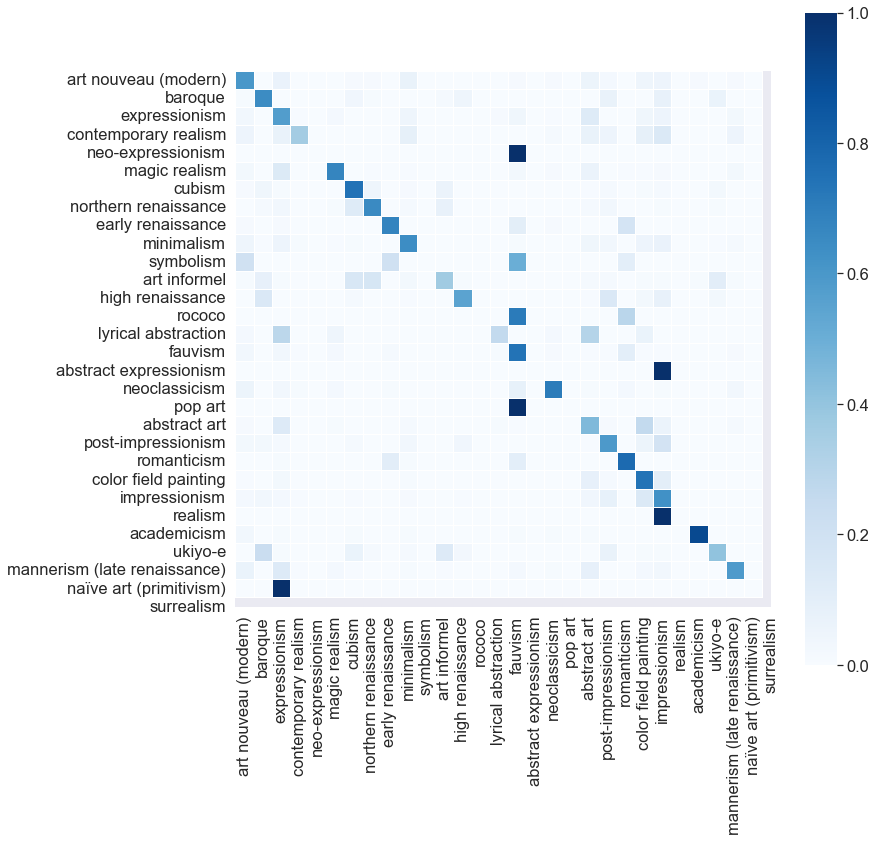

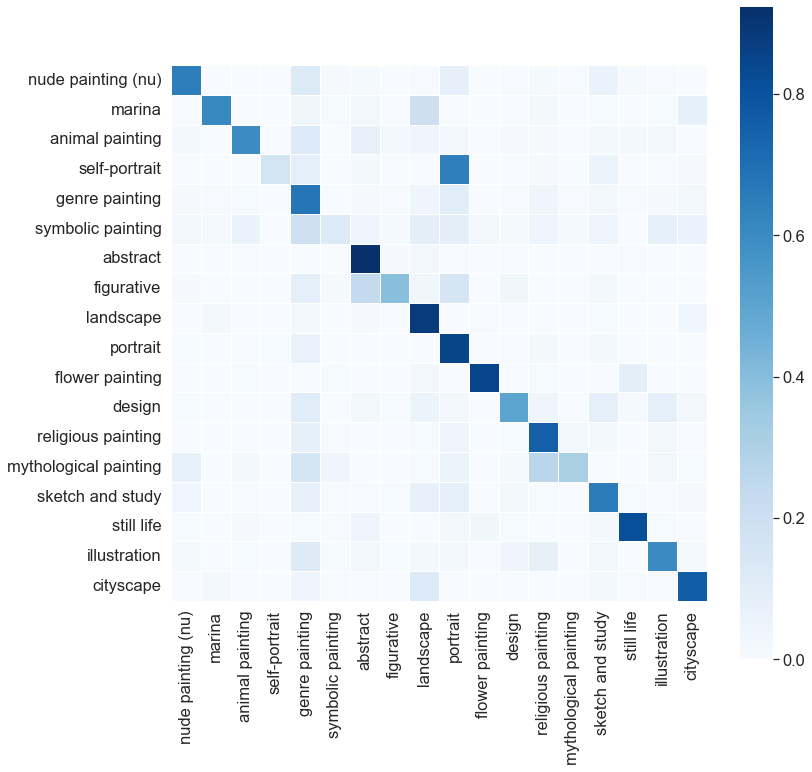

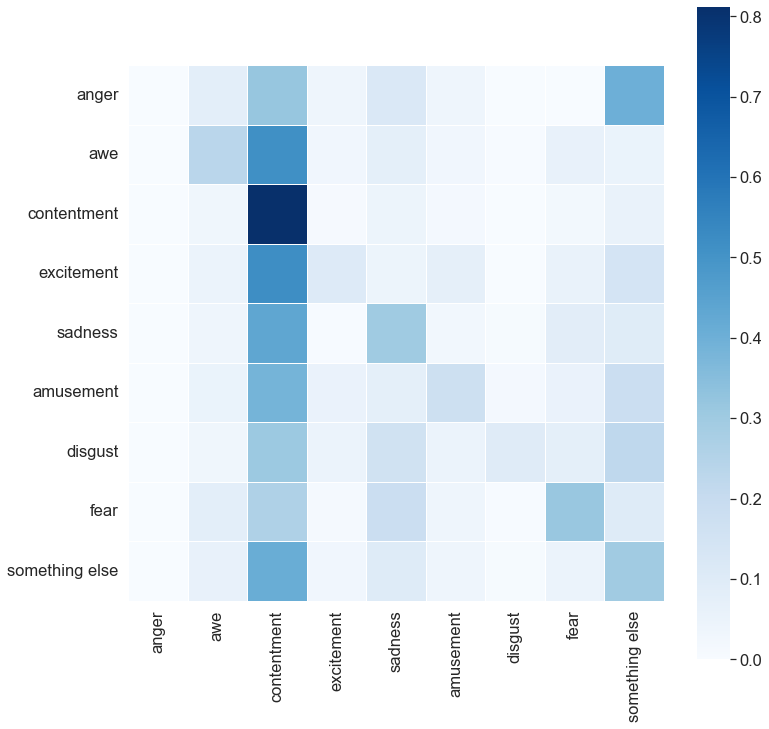

In [24]:
model = torch.load('best_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

In [25]:
results_df

,Top1,Top2,Macro-F1
style,0.623448,0.806743,0.465176
genre,0.751264,0.889349,0.631622
emotion,0.453027,0.639847,0.272616


In [26]:
results_df.to_csv('resuls_multi_task_scratch.csv')

In [27]:
model = torch.load('best_multitask_model.pt').to('cuda:0')
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
with torch.no_grad():
    pred, lab = test_func(model, test_loader, train, update_graph=True)
for task in ('style', 'genre', 'emotion'):
    results_df['Top1'].loc[task] = compute_topk(lab[task], pred[task], k=1)
    results_df['Top2'].loc[task] = compute_topk(lab[task], pred[task], k=2)
    pred_lab = torch.max(torch.Tensor(pred[task]), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(lab[task], pred_lab, average = 'macro')
    labels = pd.read_csv(f'{root}/mapping/{task}_entidx2name.csv', names = ['idx','name'])['name'].tolist()
    if task == 'style':
        labels = labels[1:-1]
    #plot_confusion_matrix(lab[task], pred_lab, hop = map_hop[task], labels = labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:06<00:00,  7.68it/s]


In [28]:
results_df

,Top1,Top2,Macro-F1
style,0.623602,0.806743,0.465356
genre,0.751418,0.889349,0.631725
emotion,0.453027,0.639847,0.272616


In [29]:
results_df.to_csv('resuls_multi_task_scratch_update.csv')